In [17]:
import pandas as pd
import numpy as np
from string import ascii_lowercase
import itertools
import string
from collections import defaultdict
import random
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)

%matplotlib inline

### Board

In [18]:
def new_game(X_cols):
    return pd.Series(0, X_cols)

def empty_positions(rows, columns):
    return {col:[row for row in rows] for col in columns}

### Winning positions

In [35]:
def rows_and_columns_checked(all_rows, all_columns):
    win_type_positions = {}
    limit_top_rows = all_rows[:-connect_n + 1]
    limit_bottom_rows = all_rows[connect_n - 1:]
    limit_right_columns =  all_columns[:-connect_n + 1]
    
    # create dictionary of win types and a tuple of the rows and columns checked for each win type
    for win_type in win_types:
        if win_type == 'up':
            rows_checked, columns_checked = limit_top_rows, all_columns
        elif win_type == 'across':
            rows_checked, columns_checked = all_rows, limit_right_columns
        elif win_type == 'diag /':
            rows_checked, columns_checked = limit_top_rows, limit_right_columns
        elif win_type == 'diag \\':
            rows_checked, columns_checked = limit_bottom_rows, limit_right_columns
        else:
            raise ValueError('not a valid win type')
        win_type_positions[win_type] = rows_checked, columns_checked

    # create dictionary of individual row/column positions and a list of their possible win types 
    positions_win_types_to_check = defaultdict(list)
    for win_type, rows_and_columns_to_check in win_type_positions.iteritems():
        for positions in itertools.product(rows_and_columns_to_check[0],rows_and_columns_to_check[1]):
            row = positions[0]
            column = positions[1]
            position = column + str(row)
            positions_win_types_to_check[position, (row, column)].append(win_type)
    return positions_win_types_to_check


def win_type_angle(win_type, row_checked, column_checked):

    # list row and column positions
    if win_type == 'up':
        angle_column_positions = list(column_checked) * connect_n
        angle_row_positions = list(map(str, range(row_checked, row_checked + connect_n)))
    elif win_type == 'across':
        angle_column_positions = list(map(chr, range(ord(column_checked), ord(column_checked) + connect_n)))
        angle_row_positions = list(str(row_checked)) * connect_n
    elif win_type == 'diag /':
        angle_column_positions = list(map(chr, range(ord(column_checked), ord(column_checked) + connect_n)))
        angle_row_positions = list(map(str, range(row_checked, row_checked + connect_n)))
    elif win_type == 'diag \\':
        angle_column_positions = list(map(chr, range(ord(column_checked), ord(column_checked) + connect_n)))
        angle_row_positions = list(map(str, range(row_checked, row_checked - connect_n, -1)))
    else:
        raise ValueError('not a valid win type')

    # combine postitions
    return [column + row for column, row in zip(angle_column_positions, angle_row_positions)]


def get_winning_positions(positions_win_types_to_check):
    winning_positions = defaultdict(list)
    for position, position_win_types in positions_win_types_to_check.iteritems():
        row = position[1][0]
        column = position[1][1]
        for win_type in position_win_types:
            additional_positions_to_check = win_type_angle(win_type, row, column)
            winning_positions[position[0]].append((win_type, additional_positions_to_check))
    return winning_positions

### Check for win

In [36]:
def determine_player(game_move_count):
    player_choice = (game_move_count + 1) % 2
    player_choice *= 2
    player_choice -= 1
    return player_choice


def available_moves(player, remaining_empty_positions):
    return [col + str(rows[0]) for col, rows in remaining_empty_positions.iteritems() if rows != list()]


def remove_empty_position(choosen_move, remaining_empty_positions):
    remaining_empty_positions[choosen_move[0]].pop(0)
    return remaining_empty_positions


def check_positions(game):
    return game[game != 0].index


def obvious_win(game, remaining_empty_positions, winning_positions, player):
    # has_best_move  BOOLEAN
    # move_to_make   STRING board_position OR NULL
    for board_position in check_positions(game):
        for win_type_angle in winning_positions[board_position]:
            game_positions_of_win_type_angle = game[win_type_angle[1]]
            win_type_angle_status = game[win_type_angle[1]].value_counts()
            if len(win_type_angle_status) == 2 and 0 in win_type_angle_status.index and player in win_type_angle_status.index:
                if win_type_angle_status.loc[0] == 1 and win_type_angle_status.loc[player] == 3:
                    winning_move = game_positions_of_win_type_angle[game_positions_of_win_type_angle == 0].index[0]
                    if winning_move in available_moves(player, remaining_empty_positions):
                        return True, winning_move
    return False, None


def predict_best_move(game, remaining_empty_positions, winning_positions, player):
    return random.choice(available_moves(player, remaining_empty_positions))


def choose_move(game, remaining_empty_positions, winning_positions, player):
    # new_board_positions  DICT all board positions
    has_obvious_win = obvious_win(game, remaining_empty_positions, winning_positions, player) 
    if has_obvious_win[0] == True:
        choosen_move = has_obvious_win[1]
        has_won_game = True
    else:
        choosen_move = predict_best_move(game, remaining_empty_positions, winning_positions, player)
        has_won_game = False
    return (choosen_move, has_won_game)


def determine_new_board_positions(game, choosen_move, player):
    game[choosen_move] = player
    return game

In [44]:
def play_game(game, remaining_empty_positions,winning_positions):
    game = new_game(X_cols)
    remaining_empty_positions = empty_positions(rows, columns)
    for game_move_count in range(len(game)):
        player = determine_player(game_move_count)
        choosen_move, has_won_game = choose_move(game, remaining_empty_positions, winning_positions, player)
        game = determine_new_board_positions(game, choosen_move, player)
        remaining_empty_positions = remove_empty_position(choosen_move, remaining_empty_positions)
        if has_won_game == True:
            return (player, game)

In [45]:
connect_n = 4
board_height = 6
board_width = 7 # max 26
columns = [column for column in ascii_lowercase[:board_width]]
rows = [row for row in range(board_height)]
X_cols = []
for column in ascii_lowercase[:board_width]:
    for row in range(board_height):
        X_cols.append(column + str(row))

In [46]:
np.random.seed(seed = 1)
X_rand = pd.DataFrame(np.random.randint(3, size=(1000, len(X_cols)), ), columns=X_cols) - 1
win_types = ['up', 'across', 'diag /', 'diag \\']
del win_type

In [48]:
positions_win_types_to_check = rows_and_columns_checked(rows, columns)
winning_positions = get_winning_positions(positions_win_types_to_check)

In [50]:
winning_positions

defaultdict(<type 'list'>, {'f0': [('up', ['f0', 'f1', 'f2', 'f3'])], 'f1': [('up', ['f1', 'f2', 'f3', 'f4'])], 'f2': [('up', ['f2', 'f3', 'f4', 'f5'])], 'b4': [('diag \\', ['b4', 'c3', 'd2', 'e1']), ('across', ['b4', 'c4', 'd4', 'e4'])], 'b5': [('diag \\', ['b5', 'c4', 'd3', 'e2']), ('across', ['b5', 'c5', 'd5', 'e5'])], 'b0': [('diag /', ['b0', 'c1', 'd2', 'e3']), ('up', ['b0', 'b1', 'b2', 'b3']), ('across', ['b0', 'c0', 'd0', 'e0'])], 'b1': [('diag /', ['b1', 'c2', 'd3', 'e4']), ('up', ['b1', 'b2', 'b3', 'b4']), ('across', ['b1', 'c1', 'd1', 'e1'])], 'b2': [('diag /', ['b2', 'c3', 'd4', 'e5']), ('up', ['b2', 'b3', 'b4', 'b5']), ('across', ['b2', 'c2', 'd2', 'e2'])], 'b3': [('diag \\', ['b3', 'c2', 'd1', 'e0']), ('across', ['b3', 'c3', 'd3', 'e3'])], 'd4': [('diag \\', ['d4', 'e3', 'f2', 'g1']), ('across', ['d4', 'e4', 'f4', 'g4'])], 'd5': [('diag \\', ['d5', 'e4', 'f3', 'g2']), ('across', ['d5', 'e5', 'f5', 'g5'])], 'd2': [('diag /', ['d2', 'e3', 'f4', 'g5']), ('up', ['d2', 'd3', 'd

In [32]:
random.seed(0)
# all_cols = X_cols.append("Winner")
df = pd.DataFrame(columns = X_cols)

In [412]:
number_of_games = 1000

In [414]:
%%time
for game_number in range(number_of_games):
    winner, game_result = play_game(game, remaining_empty_positions, winning_positions)
    game_info = game_result.append(pd.Series(winner, index = ['Winner']))
    df = df.append(game_info, ignore_index=True)
    df = df.append(game_info * -1, ignore_index=True)

CPU times: user 3min 25s, sys: 1.07 s, total: 3min 26s
Wall time: 3min 26s


In [421]:
%%time
for game_number in range(10):
    winner, game_result = play_game(game, remaining_empty_positions, winning_positions)
    game_info = game_result.append(pd.Series(winner, index = ['Winner']))
    df = df.append(game_info, ignore_index=True)
    df = df.append(game_info * -1, ignore_index=True)

CPU times: user 1.45 s, sys: 22.7 ms, total: 1.47 s
Wall time: 1.46 s


In [429]:
df[df.index.map(lambda x: x % 2) == 0].Winner.value_counts()

 1    681
-1    440
dtype: int64

In [430]:
df[df.index.map(lambda x: x % 2) == 0].loc[:,:'g5'].sum(axis = 1).sum()

681.0

In [427]:
moves_per_game = (df.loc[:,:'g5'] != 0).sum(axis = 1).value_counts().sort_index()

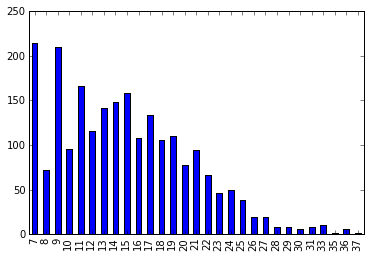

In [428]:
moves_per_game.plot(kind = 'bar')